# Tuning the model hyperparameter
This notebook uses the package `ray` to run the models using different sets of hyperparameter.
Then, we rank the set of hyperparameter with the exact solution.

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net
from functools import partial
from ray import tune, init

init(num_cpus=4, num_gpus=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The formula given by Borodin

In [2]:
lower_bound, upper_bound = -10, 10

def conditional_probability_to_survive(t, x, y, k_arr=range(-5, 5)):
    ans = 0
    for k in k_arr:
        ans += (
                torch.exp(((y - x) ** 2 - (y - x + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
                - torch.exp(((y - x) ** 2 - (y + x - 2 * lower_bound + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
        )
    return ans.prod(dim=0)

def is_x_inside(x):
    return torch.logical_and(lower_bound <= x, x <= upper_bound).all(dim=0)

def tune_wrapper(config, grid_d_dim_with_t=None, true=None, tune_report=True, x=None, y=None, seed=0):
    torch.manual_seed(seed)
    model = Net(**config)
    if tune_report:
        output_dict = model.train_and_eval(debug_mode=False, return_dict=True, x=x, y=y)
        nn = (
            model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=model.patches-1)
                .detach()
                .cpu()
                .numpy()
        )
        tune.report(runtime=output_dict[f"patch_{model.patches-1}"][0], test_max_error=np.abs(true - nn).max())
    else:
        x, y = model.gen_sample(patch=model.patches-1)
        return x, y

## Tuning using Kuramoto equation 1

In [3]:
alpha, beta, gamma = 1, 4, 1
nu = 2 * alpha

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        15
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 1
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

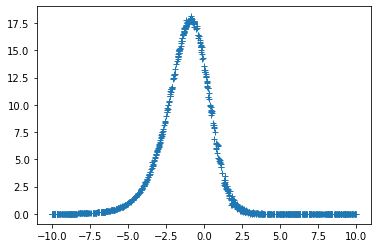

In [4]:
config = {
    "f_fun": f_example,
    "deriv_map": deriv_map,
    "phi_fun": phi_example,
    "conditional_probability_to_survive": conditional_probability_to_survive,
    "is_x_inside": is_x_inside,
    "device": device,
    "x_lo": x_lo,
    "x_hi": x_hi,
    "T": T,
    "verbose": False,
    "nu": nu,
    "branch_patches": patches,
    "branch_nb_path_per_state": 1000,
    "outlier_multiplier": 50,
    "save_for_best": True,
}
x, y = tune_wrapper(config, tune_report=False)
plt.plot(x[:, 1].cpu(), y.cpu(), '+')

config.update({
    "branch_lr": tune.choice([1e-1, 1e-2, 1e-3]),
    "epochs": tune.choice([3000, 5000, 8000]),
    "layers": tune.choice([4, 5, 6]),
    "neurons": tune.choice([20, 50, 100]),
    "lr_gamma": tune.choice([.1, .5, .8]),
    "branch_activation": tune.choice(["tanh", "relu", "softplus"]),
    "batch_normalization": tune.choice([True, False]),
})

In [5]:
runs = 500
scheduler = tune.schedulers.ASHAScheduler(
    metric="test_max_error",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)
reporter = tune.JupyterNotebookReporter(
    overwrite=True,
    metric_columns=["test_max_error", "runtime"],
    max_progress_rows=runs,
    metric="test_max_error",
    mode="min",
    sort_by_metric=True,
)

In [6]:
# better parameters:
#     - batch_normalization=True
#     - branch_activation=softplus
#     - layers=6
#     - neurons=50
#     - branch_lr=1e-3
#     - epochs=5000
# at this stage, it is better to use lr_gamma=0.8 (see below)
result = tune.run(
    partial(tune_wrapper, grid_d_dim_with_t=grid_d_dim_with_t, true=true, x=x, y=y, seed=0),
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=config,
    num_samples=runs,
    scheduler=scheduler,
    progress_reporter=reporter,
)

Trial name,status,loc,batch_normalization,branch_activation,branch_lr,epochs,layers,lr_gamma,neurons,test_max_error,runtime
tune_wrapper_fa546_00158,TERMINATED,172.17.244.13:16977,True,softplus,0.001,5000,6,0.5,50,0.2831,33.447
tune_wrapper_fa546_00004,TERMINATED,172.17.244.13:10775,True,softplus,0.01,3000,6,0.8,20,0.30646,19.1092
tune_wrapper_fa546_00148,TERMINATED,172.17.244.13:16574,True,softplus,0.001,3000,4,0.1,20,0.319255,15.1917
tune_wrapper_fa546_00379,TERMINATED,172.17.244.13:25790,True,softplus,0.001,5000,4,0.1,50,0.321559,26.9804
tune_wrapper_fa546_00231,TERMINATED,172.17.244.13:19857,True,softplus,0.001,5000,4,0.1,20,0.322557,25.8318
tune_wrapper_fa546_00024,TERMINATED,172.17.244.13:11589,True,softplus,0.001,3000,6,0.5,50,0.322635,19.8476
tune_wrapper_fa546_00127,TERMINATED,172.17.244.13:15728,True,softplus,0.001,5000,6,0.1,50,0.327471,33.5671
tune_wrapper_fa546_00171,TERMINATED,172.17.244.13:17475,True,softplus,0.001,3000,6,0.1,50,0.327792,20.3005
tune_wrapper_fa546_00228,TERMINATED,172.17.244.13:19735,True,softplus,0.001,3000,4,0.5,50,0.329435,15.5613
tune_wrapper_fa546_00211,TERMINATED,172.17.244.13:19054,True,softplus,0.1,8000,4,0.8,20,0.329558,40.9359


TuneError: ('Trials did not complete', [tune_wrapper_fa546_00114, tune_wrapper_fa546_00163])

In [19]:
config = {
    "f_fun": f_example,
    "deriv_map": deriv_map,
    "phi_fun": phi_example,
    "conditional_probability_to_survive": conditional_probability_to_survive,
    "is_x_inside": is_x_inside,
    "device": device,
    "x_lo": x_lo,
    "x_hi": x_hi,
    "T": T,
    "verbose": False,
    "nu": nu,
    "branch_patches": patches,
    "branch_nb_path_per_state": 1000,
    "outlier_multiplier": 50,
    "save_for_best": True,
    "branch_lr": 1e-3,
    "epochs": 5000,
    "layers": 6,
    "neurons": 50,
    "branch_activation": "softplus",
    "batch_normalization": True,
}
config.update({
    "lr_gamma": tune.choice([.5, .8]),
#     "lr_gamma": .5,
})

In [20]:
result = tune.run(
    partial(tune_wrapper, grid_d_dim_with_t=grid_d_dim_with_t, true=true, x=x, y=y, seed=6),
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=config,
    num_samples=runs,
    scheduler=scheduler,
    progress_reporter=reporter,
)

Trial name,status,loc,lr_gamma,test_max_error,runtime
tune_wrapper_0ee7d_00002,RUNNING,172.17.244.13:4399,0.8,,
tune_wrapper_0ee7d_00003,PENDING,,0.5,,
tune_wrapper_0ee7d_00004,PENDING,,0.5,,
tune_wrapper_0ee7d_00005,PENDING,,0.8,,
tune_wrapper_0ee7d_00006,PENDING,,0.8,,
tune_wrapper_0ee7d_00007,PENDING,,0.8,,
tune_wrapper_0ee7d_00008,PENDING,,0.5,,
tune_wrapper_0ee7d_00009,PENDING,,0.5,,
tune_wrapper_0ee7d_00010,PENDING,,0.5,,
tune_wrapper_0ee7d_00011,PENDING,,0.5,,


2022-05-19 09:16:41,845	ERROR tune.py:697 -- Trials did not complete: [tune_wrapper_0ee7d_00002, tune_wrapper_0ee7d_00003, tune_wrapper_0ee7d_00004, tune_wrapper_0ee7d_00005, tune_wrapper_0ee7d_00006, tune_wrapper_0ee7d_00007, tune_wrapper_0ee7d_00008, tune_wrapper_0ee7d_00009, tune_wrapper_0ee7d_00010, tune_wrapper_0ee7d_00011, tune_wrapper_0ee7d_00012, tune_wrapper_0ee7d_00013, tune_wrapper_0ee7d_00014, tune_wrapper_0ee7d_00015, tune_wrapper_0ee7d_00016, tune_wrapper_0ee7d_00017, tune_wrapper_0ee7d_00018]
2022-05-19 09:16:41,846	INFO tune.py:701 -- Total run time: 121.24 seconds (109.89 seconds for the tuning loop).
2022-05-19 09:16:41,847	WARNING tune.py:707 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`
